In [2]:
import umap
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.spatial import ConvexHull
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output

In [58]:
# Get the embeddings
real_embeddings = np.load("../results/embeddings/hypotheses-falcon-7b-no_steer-real.npy")
synthetic_embeddings = np.load("../results/embeddings/hypotheses-falcon-7b-no_steer-synthetic.npy")

In [59]:
def compute_umap_and_hulls(synthetic_embeddings, real_embeddings, n_neighbors=150, separate_umap=False):
    # Choose whether to compute UMAP embeddings separately and then concatenate
    if separate_umap:
        # Standardize the data after
        scaler = StandardScaler()

        # Calculate UMAP embeddings separately
        synthetic_umap_embeddings = umap.UMAP(n_components=2, n_neighbors=n_neighbors).fit_transform(synthetic_embeddings)
        real_umap_embeddings = umap.UMAP(n_components=2, n_neighbors=n_neighbors).fit_transform(real_embeddings)
        synthetic_umap_embeddings = scaler.fit_transform(synthetic_umap_embeddings)
        real_umap_embeddings = scaler.fit_transform(real_umap_embeddings)

    else:
        # Combine synthetic and real embeddings for UMAP fitting
        combined_embeddings = np.vstack((synthetic_embeddings, real_embeddings))

        # Reduce dimensionality with UMAP
        umap_embeddings = umap.UMAP(n_components=2, n_neighbors=n_neighbors).fit_transform(combined_embeddings)

        # Split the UMAP embeddings back into synthetic and real
        num_synthetic = len(synthetic_embeddings)
        synthetic_umap_embeddings = umap_embeddings[:num_synthetic]
        real_umap_embeddings = umap_embeddings[num_synthetic:]

    # Compute convex hulls
    synthetic_hull = ConvexHull(synthetic_umap_embeddings)
    real_hull = ConvexHull(real_umap_embeddings)

    return synthetic_umap_embeddings, real_umap_embeddings, synthetic_hull, real_hull

def plot_umap(real_umap_embeddings, synthetic_umap_embeddings, real_hull=None, synthetic_hull=None):
    # Reset plt style
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (8, 6)

    # Put tiny white borders around dotted scatter points
    plt.scatter(real_umap_embeddings[:, 0], real_umap_embeddings[:, 1], c="cornflowerblue", label="Real", edgecolor='white')
    plt.scatter(synthetic_umap_embeddings[:, 0], synthetic_umap_embeddings[:, 1], c="firebrick", label="Synthetic", edgecolor='white')

    vibrant_green = (117/255, 251/255, 76/255)

    if real_hull is not None:
        for simplex in real_hull.simplices:
            plt.plot(real_umap_embeddings[simplex, 0], real_umap_embeddings[simplex, 1], color=vibrant_green)

    if synthetic_hull is not None:
        for simplex in synthetic_hull.simplices:
            plt.plot(synthetic_umap_embeddings[simplex, 0], synthetic_umap_embeddings[simplex, 1], 'k-')

    plt.xlabel("UMAP dimension 1")
    plt.ylabel("UMAP dimension 2")
    # Set a grid on the plot
    plt.grid()
    # Make the grid lighter
    plt.gca().set_axisbelow(True)
    # No outline
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # Put the ticks on the inside of the axes
    plt.gca().tick_params(axis='x', direction='in')
    plt.gca().tick_params(axis='y', direction='in')
    # Legend
    plt.legend()
    plt.show()

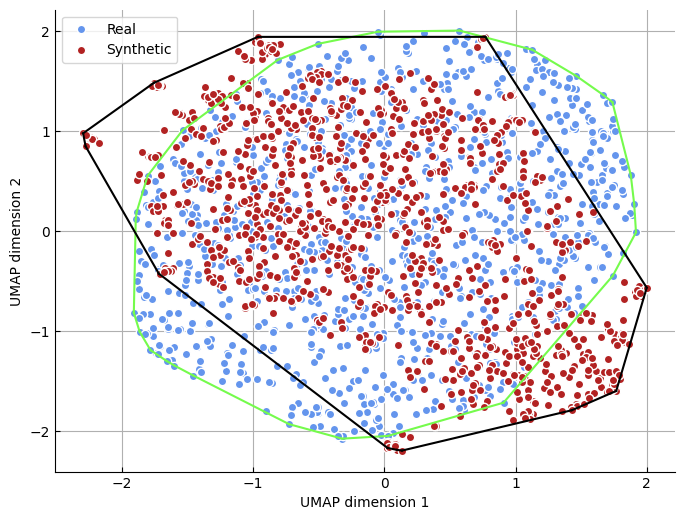

In [60]:
# Now you can use this function to compute UMAP and hulls, and then plot them
synthetic_umap_embeddings, real_umap_embeddings, synthetic_hull, real_hull = compute_umap_and_hulls(synthetic_embeddings, real_embeddings, separate_umap=True)
plot_umap(real_umap_embeddings, synthetic_umap_embeddings, real_hull, synthetic_hull)

In [61]:
embeddings_dict = {
    'Llama-65B': {
        'Arxiv': (real_embeddings, synthetic_embeddings),
        'Jigsaw': (real_embeddings, synthetic_embeddings),
        'CommonsenseQA': (real_embeddings, synthetic_embeddings),
    },
    'Falcon-7B': {
        'Arxiv': (real_embeddings, synthetic_embeddings),
        'Jigsaw': (real_embeddings, synthetic_embeddings),
        'CommonsenseQA': (real_embeddings, synthetic_embeddings),
    },
    'GPT-NeoX-20B': {
        'Arxiv': (real_embeddings, synthetic_embeddings),
        'Jigsaw': (real_embeddings, synthetic_embeddings),
        'CommonsenseQA': (real_embeddings, synthetic_embeddings),
    },
}

<Figure size 5000x5000 with 0 Axes>

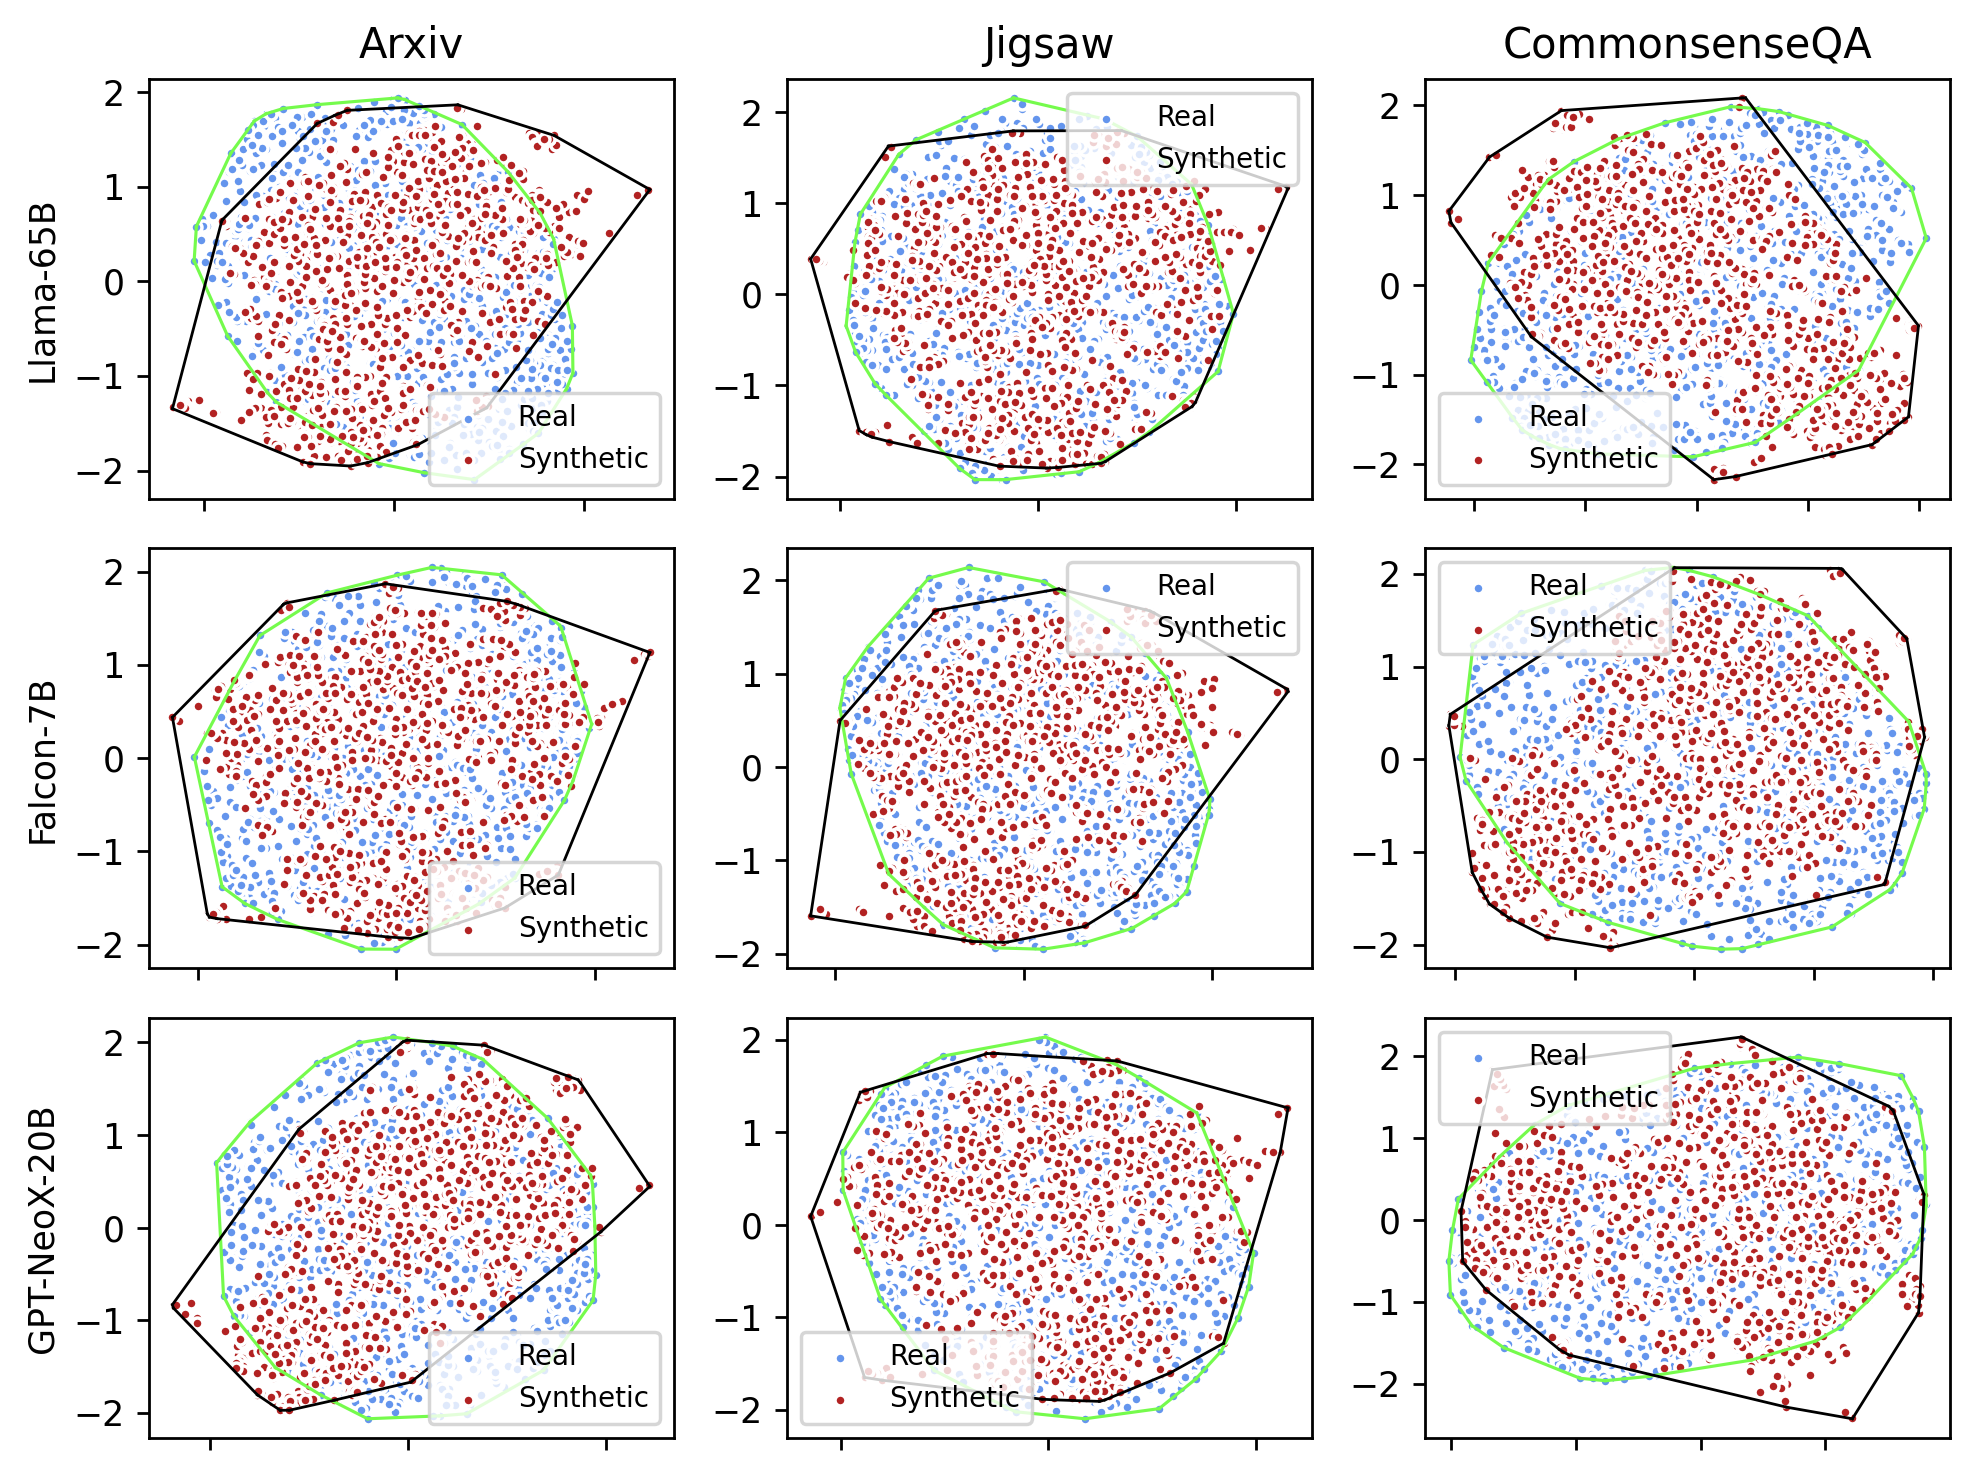

In [69]:
# Size of the figure
plt.figure(figsize=(20, 20))

# Set the DPI to be higher
plt.rcParams['figure.dpi'] = 250

# Create the subplots
fig, axs = plt.subplots(3, 3)

# Get model and dataset names
models = list(embeddings_dict.keys())
datasets = list(embeddings_dict[models[0]].keys())

# Loop over the models
for i, model in enumerate(models):
    # Loop over the datasets
    for j, dataset in enumerate(datasets):
        # Compute the UMAP and hulls
        real_embeddings, synthetic_embeddings = embeddings_dict[model][dataset]
        synthetic_umap_embeddings, real_umap_embeddings, synthetic_hull, real_hull = compute_umap_and_hulls(synthetic_embeddings, real_embeddings,
                                                                                                            separate_umap=True)

        # Plot the UMAP embeddings and hulls, with small dots
        axs[i, j].scatter(real_umap_embeddings[:, 0], real_umap_embeddings[:, 1], c="cornflowerblue", label="Real", edgecolor='white', s=10)
        axs[i, j].scatter(synthetic_umap_embeddings[:, 0], synthetic_umap_embeddings[:, 1], c="firebrick", label="Synthetic", edgecolor='white', s=10)

        vibrant_green = (117/255, 251/255, 76/255)

        if real_hull is not None:
            for simplex in real_hull.simplices:
                axs[i, j].plot(real_umap_embeddings[simplex, 0], real_umap_embeddings[simplex, 1], color=vibrant_green, linewidth=0.9)

        if synthetic_hull is not None:
            for simplex in synthetic_hull.simplices:
                axs[i, j].plot(synthetic_umap_embeddings[simplex, 0], synthetic_umap_embeddings[simplex, 1], 'k-', linewidth=0.8)
        
        # Set row and column labels
        if j == 0:
            axs[i, j].set_ylabel(model)
        if i == 0:
            axs[i, j].set_title(dataset)
        
        # Set legend fontsize as 8
        axs[i, j].legend(fontsize=8)
        # Remove tick labels but keep ticks
        axs[i, j].set_xticklabels([])

plt.tight_layout()
plt.savefig("../paper/figures/umap.pdf", bbox_inches="tight")
plt.show()

## Train an adversarial classifier

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

# Load the data
real_embeddings = np.load("../results/embeddings/hypotheses-falcon-7b-no_steer-real.npy")
synthetic_embeddings = np.load("../results/embeddings/hypotheses-falcon-7b-no_steer-synthetic.npy")

# Create labels
real_labels = np.ones(len(real_embeddings))
synthetic_labels = np.zeros(len(synthetic_embeddings))

# Combine the data
data = np.vstack((real_embeddings, synthetic_embeddings))
labels = np.concatenate((real_labels, synthetic_labels))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train the model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Evaluate the model with accuracy and ROC_AUC
print(f"ROC_AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")
print(f"Accuracy: {accuracy_score(y_test, model.predict(X_test))}")

ROC_AUC: 0.673116827920698
Accuracy: 0.6375


In [5]:
# Now let's do the same as above, except with k-fold cross-validation
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

# Load the data
real_embeddings = np.load("../results/embeddings/hypotheses-falcon-7b-no_steer-real.npy")
synthetic_embeddings = np.load("../results/embeddings/hypotheses-falcon-7b-no_steer-synthetic.npy")

# Create labels
real_labels = np.ones(len(real_embeddings))
synthetic_labels = np.zeros(len(synthetic_embeddings))

# Combine the data
data = np.vstack((real_embeddings, synthetic_embeddings))
labels = np.concatenate((real_labels, synthetic_labels))

# Create the k-fold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to store the results
roc_auc_scores = []
accuracy_scores = []

# Iterate over the folds
for train_index, test_index in tqdm(kf.split(data)):
    # Split the data
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    # Train the model
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    # Evaluate the model with accuracy and ROC_AUC
    roc_auc_scores.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    accuracy_scores.append(accuracy_score(y_test, model.predict(X_test)))

# Print the results
print(f"ROC_AUC: {np.mean(roc_auc_scores)}")
print(f"Accuracy: {np.mean(accuracy_scores)}")

0it [00:00, ?it/s]

ROC_AUC: 0.6713400025821679
Accuracy: 0.651


In [12]:
# Now let's try classifying the umap embeddings

# Load the data
real_embeddings = np.load("../results/embeddings/hypotheses-falcon-7b-no_steer-real.npy")
synthetic_embeddings = np.load("../results/embeddings/hypotheses-falcon-7b-no_steer-synthetic.npy")

# Create labels
real_labels = np.ones(len(real_embeddings))
synthetic_labels = np.zeros(len(synthetic_embeddings))

# Combine the data
data = np.vstack((real_embeddings, synthetic_embeddings))
labels = np.concatenate((real_labels, synthetic_labels))

# Compute UMAP embeddings
umap_embeddings = umap.UMAP(n_components=2, n_neighbors=150).fit_transform(data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(umap_embeddings, labels, test_size=0.2, random_state=42)

# Train the model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Evaluate the model with accuracy and ROC_AUC
print(f"ROC_AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")
print(f"Accuracy: {accuracy_score(y_test, model.predict(X_test))}")

ROC_AUC: 0.6199654991374784
Accuracy: 0.595


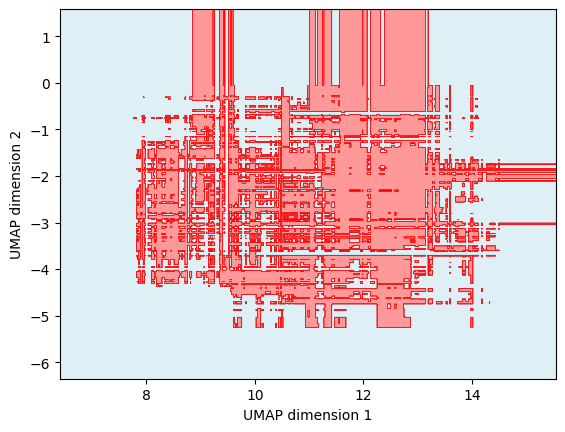

In [14]:
# Plot decision boundary
from matplotlib.colors import ListedColormap

# Create a meshgrid
x_min, x_max = umap_embeddings[:, 0].min() - 1, umap_embeddings[:, 0].max() + 1
y_min, y_max = umap_embeddings[:, 1].min() - 1, umap_embeddings[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Compute predictions
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['lightblue', 'red']))
#plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap=ListedColormap(['blue', 'darkred']))
plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")
plt.show()

In [15]:
# Now let's do the same as above, but calculate the UMAP separately
from sklearn.preprocessing import StandardScaler

# Load the data
real_embeddings = np.load("../results/embeddings/hypotheses-falcon-7b-no_steer-real.npy")
synthetic_embeddings = np.load("../results/embeddings/hypotheses-falcon-7b-no_steer-synthetic.npy")

# Create labels
real_labels = np.ones(len(real_embeddings))
synthetic_labels = np.zeros(len(synthetic_embeddings))

# Standardize the data first
scaler = StandardScaler()
#real_embeddings = scaler.fit_transform(real_embeddings)
#synthetic_embeddings = scaler.fit_transform(synthetic_embeddings)

# Calculate UMAP embeddings separately
real_umap_embeddings = umap.UMAP(n_components=2, n_neighbors=150).fit_transform(real_embeddings)
synthetic_umap_embeddings = umap.UMAP(n_components=2, n_neighbors=150).fit_transform(synthetic_embeddings)
real_umap_embeddings = scaler.fit_transform(real_umap_embeddings)
synthetic_umap_embeddings = scaler.fit_transform(synthetic_umap_embeddings)

# Combine the data
data = np.vstack((real_umap_embeddings, synthetic_umap_embeddings))
labels = np.concatenate((real_labels, synthetic_labels))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train the model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Evaluate the model with accuracy and ROC_AUC
print(f"ROC_AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")
print(f"Accuracy: {accuracy_score(y_test, model.predict(X_test))}")

ROC_AUC: 0.6329783244581114
Accuracy: 0.5875


Text(0, 0.5, 'UMAP dimension 2')

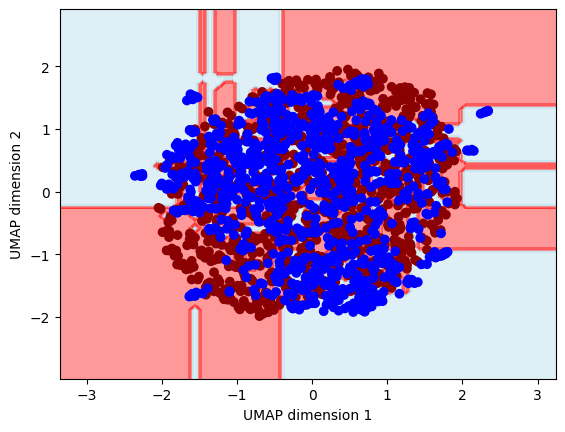

In [16]:
# Plot decision boundary
from matplotlib.colors import ListedColormap

# Create a meshgrid
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Compute predictions
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['lightblue', 'red']))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=ListedColormap(['blue', 'darkred']))
plt.xlabel("UMAP dimension 1")
plt.ylabel("UMAP dimension 2")

# Downstream

## Jigsaw

In [ ]:
# Load real data
